This notebook is aimed at modelling the non-linear water flow and sand formations on a beach.

Features:
  * water component with density and momentum (Water is incompressible, so it's a cell-wise momentum
  * Incoming wave from sea
  * Sand drag

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook
import matplotlib as mpl

import scipy.signal as signal
import scipy.ndimage as ndimage
import numba
from numba import jit, njit

import copy
from importlib import reload
import matplotlib.animation as animation
from IPython.display import HTML

import skimage.transform as sktransform 
from skimage import color, morphology

plt.rcParams["animation.html"] = "jshtml"

import pickle


import popdyn.flow as flow

# Create Shore box

In [246]:
np.random.seed(10)
xsize = 200
ysize = 200

scatter = 0.05

slope = 0.3

In [247]:
land = np.zeros((xsize, ysize))
land += np.random.random(size=xsize*ysize).reshape(land.shape) * scatter

xarr = np.linspace(0, 2, xsize)
yarr = np.linspace(0, 2, ysize)
xx, yy = np.meshgrid(xarr, yarr)

hh = yy * slope
land += hh



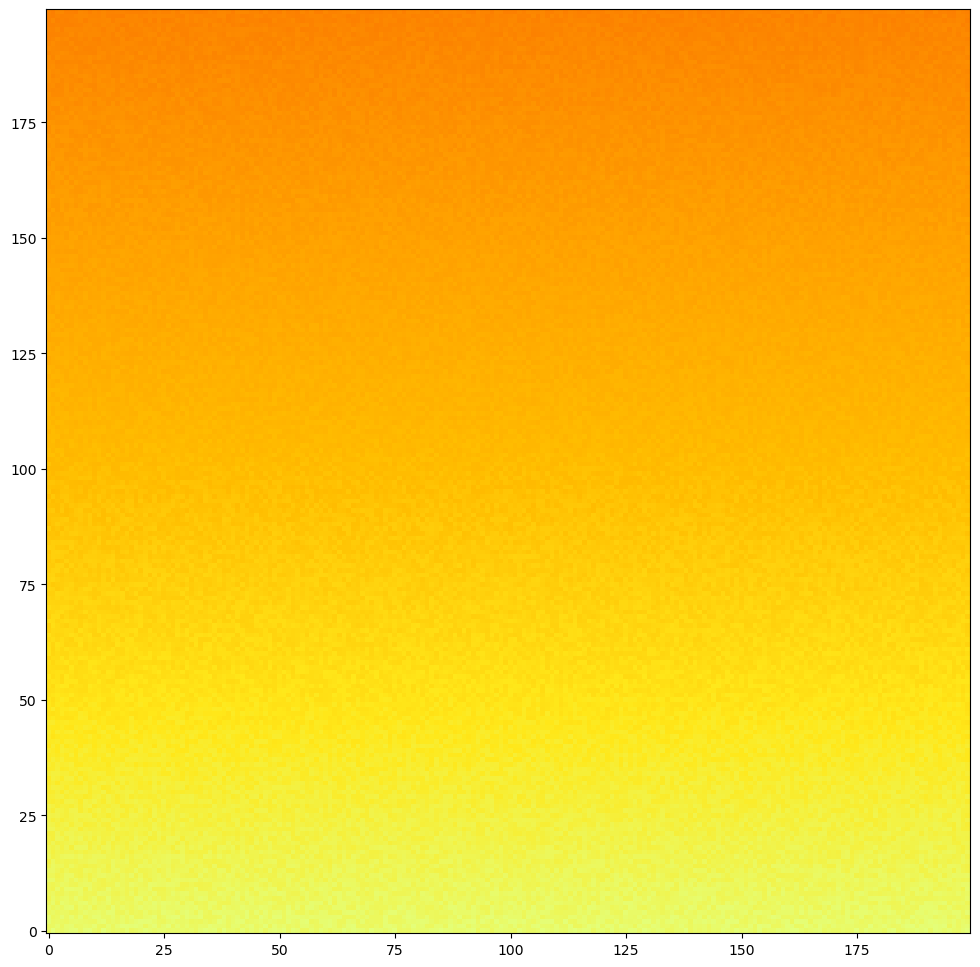

In [248]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
plt.imshow(land, cmap=plt.cm.Wistia, vmin=0, vmax=land.max(), origin="lower")

# Build an interaction model

In [249]:
def calc_shifted(inmap):
    """shift up, down, left, right"""

    omap = []
    tmp = np.roll(inmap, -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    tmp = np.roll(inmap, 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     
    return np.array(omap)   

def calc_unshifted(inmap):
    omap = []

    tmp = np.roll(inmap[0, :, :], 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[1, :, :], -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[2, :, :], 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     

    tmp = np.roll(inmap[3, :, :], -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    return np.array(omap)

def center_cut(arr):
    return arr[1:-1, 1:-1]

def null_edges(arr):
    arr[0, :] = 0.
    arr[:, 0] = 0.
    arr[:, -1] = 0.
    arr[-1, :] = 0.
    return arr

In [250]:
def pad(canvases):
    """padsfor each canvas pad the 2d array"""
    keys = canvases.keys()
    padded_canvases = {}
    for key in keys:
        arr = canvases[key]
        arr = np.pad(arr, pad_width=1, mode="edge")
        padded_canvases.update({key: arr})
    return padded_canvases

class CellSpace(object):
    def __init__(self, initial_maps, rules):
        """
        Cell automata, considers the direct neighbor cells only
        
        Initialize with a dict of initial maps in the style
        
        initial_maps = {
            "layer_name": initial map,
        }
        
        The rules are a similar dictionary of class instances which will be passed 
        
        
        """
        self.canvases = copy.deepcopy(initial_maps)
        self.layers = list(initial_maps.keys())
        self.padded_canvases = pad(self.canvases)

        self.shape_canvas = self.canvases[self.layers[0]].shape
        self.shape_canvas_padded = self.padded_canvases[self.layers[0]].shape
    
        self.imap = np.arange(len(self.canvases[self.layers[0]].flatten())).reshape(self.shape_canvas)
        self.imap_padded = np.arange(len(self.padded_canvases[self.layers[0]].flatten())).reshape(self.shape_canvas_padded)
        self.imap_center = center_cut(self.imap_padded)
        self.imap_shifted = [center_cut(tmp) for tmp in calc_shifted(self.imap_padded)]
        self.imap_unshifted = [
            self.imap_shifted[1],
            self.imap_shifted[0],
            self.imap_shifted[3],
            self.imap_shifted[2],
        ]
        
        self.shifted_canvases = self.shift()
        self.rules = rules
        
        self.maps = {}
        self.reset_maps()
            
    def update_maps(self):
        for key in self.layers:
            self.maps[key].append(self.canvases[key].copy())
            
    def reset_maps(self):
        self.maps = {}
        for key in self.layers:
#             dd = {key: [self.canvases[key],]}
            dd = {key: []}
            self.maps.update(dd)            
       
    def shift(self):
        shifted_canvases = {}
        for key in self.canvases.keys():
            arr = np.array([self.padded_canvases[key].flat[ii] for ii in self.imap_shifted])
            shifted_canvases.update({key: arr})
        return shifted_canvases
            
            
    def step(self):
        
        new_canvases = {}
        for rule in self.rules:
            canvas = rule.evolve(self)
            new_canvases.update(canvas)
            
        self.canvases = new_canvases
        self.padded_canvases = pad(self.canvases)
        self.shifted_canvases = self.shift()


    def flow(self, nstep=100, savestep=5):
        """
        a series of steps
        """
        self.reset_maps()
        self.update_maps()
        for i in np.arange(nstep):
#             print(str(i) + ' out of ' + str(nstep-1), end="\r")
            print(str(i) + ' out of ' + str(nstep-1), end="\n")
            self.step()
            if i % savestep == 0:
                self.update_maps()

In [251]:
class BeachFlow(FlowRule):
    def __init__(self, water_flow_rate=0.5, drag_coeff=0.1):
        """
        This is a four component erosion model with glaciers
        
        This is a three component erosion model where water flows fast, and drags a fraction of the land with it
        Any land once dragged, will becone gravel, which erodes very easily
        
        wflow_rate is the water flaw per time step
        lflow rate is the land coerosion per time step, this should be much smaller than the water flow rate
        gravel_factor is the multiplier to the land coerosion rate
        
        The local gradient step is determined by the total land plus water height,
        and each component is dragged separately
        
        this is the lazy river approximation, where the velocity of water is negligible. Perhaps this is a mistake
        
        """
        self.layers = np.sort(("sand", "water",))
        self.wkey = "water"
        self.lkey = "sand"
        self.water_flow_rate = water_flow_rate
        self.drag_coeff = drag_coeff
    
    
    def evolve(self, cell):
        """
        It is interesting that the outflow direction is set by land + gravel,
        but the amount of drag possible is two
        """
#         np.set_printoptions(suppress=True)

        # these are the only canvases we are going to care about at all
        sand_local = cell.canvases[self.lkey]
        sand_shifted = cell.shifted_canvases[self.lkey]
                
        water_local = cell.canvases[self.wkey]
        water_shifted = cell.shifted_canvases[self.wkey]
        
        height_local = sand_local + water_local 
        height_shifted = sand_shifted + water_shifted

        # 1) water flows along the gradient
        diffs = height_local - height_shifted
        diffs[diffs < 0] = 0
        fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        outflow_w = water_local * fractions * self.water_flow_rate
        print(outflow_w.mean())
        water_local = self.calc_flows(water_local, outflow_w, cell)

#         outflow_s = outflow_w * self.drag_coeff
#         ii = outflow_s > sand_local / 4.
#         outflow_s[ii] = (sand_local / 4.)[ii]
#         sand_local = self.calc_flows(sand_local, outflow_s, cell)

        resdict = cell.canvases
        resdict.update({self.wkey: water_local, self.lkey: sand_local})
        
#         np.set_printoptions(suppress=False)
        return resdict    
        

In [284]:
rules = (
    BeachFlow(water_flow_rate=0.9, drag_coeff=0.5),
)
wmap = np.zeros(shape=land.shape)
wmap[-1, 50:150] = 100
initial_maps = {
    "sand": land*2,
    "water": wmap,
}

In [286]:
cs = CellSpace(initial_maps, rules)
cs.flow(10000, savestep=20)

sands = copy.deepcopy(cs.maps["sand"])
waters = copy.deepcopy(cs.maps["water"])

0 out of 9999
0.05625
1 out of 9999
0.05422308376883477
2 out of 9999
0.05442510847457598
3 out of 9999
0.05404480366280269
4 out of 9999
0.054111689660022104
5 out of 9999
0.05368873245533598
6 out of 9999
0.05356622835098277
7 out of 9999
0.053449335175014163
8 out of 9999
0.05366345382846721
9 out of 9999
0.05330335579017858
10 out of 9999
0.05355989419609431
11 out of 9999
0.05308008362801604
12 out of 9999
0.053293166342754855
13 out of 9999
0.05299199202571358
14 out of 9999
0.053033999776890106
15 out of 9999
0.05287543283859352
16 out of 9999
0.052878861970420715
17 out of 9999
0.05286613123206813
18 out of 9999
0.05284510560428604
19 out of 9999
0.05277222815001815
20 out of 9999
0.05279147944898167
21 out of 9999
0.05260588697494162
22 out of 9999
0.052651720052740936
23 out of 9999
0.05251590932753371
24 out of 9999
0.05264249405491993
25 out of 9999
0.052506184298473604
26 out of 9999
0.05258960063550891
27 out of 9999
0.05246203436494515
28 out of 9999
0.052532805548246846

/tmp/ipykernel_6733/2152556845.py:46: RuntimeWarning: invalid value encountered in true_divide
  fractions = np.nan_to_num(diffs / diffs.sum(axis=0))


0.05219923918103715
40 out of 9999
0.05228573360449268
41 out of 9999
0.05218546852528435
42 out of 9999
0.05226949872050892
43 out of 9999
0.05217030493462993
44 out of 9999
0.05222042255464978
45 out of 9999
0.0521660834750298
46 out of 9999
0.05220669121111979
47 out of 9999
0.052162018098281124
48 out of 9999
0.05215527418423702
49 out of 9999
0.0521457989313753
50 out of 9999
0.052143922262288735
51 out of 9999
0.052137361674302135
52 out of 9999
0.052123225461719665
53 out of 9999
0.05212389743072158
54 out of 9999
0.05211194817345579
55 out of 9999
0.05211074804154249
56 out of 9999
0.05210935667760881
57 out of 9999
0.05210356680699737
58 out of 9999
0.052094579419742444
59 out of 9999
0.0520857231372868
60 out of 9999
0.052081156262274546
61 out of 9999
0.052062364430063415
62 out of 9999
0.052073488619487386
63 out of 9999
0.05205348693975774
64 out of 9999
0.052057372049839956
65 out of 9999
0.05205022306778215
66 out of 9999
0.05205054877080122
67 out of 9999
0.052037118807

284 out of 9999
0.05179551180482863
285 out of 9999
0.051827753599093786
286 out of 9999
0.05179803932046341
287 out of 9999
0.05182665124876149
288 out of 9999
0.051795922214976725
289 out of 9999
0.05182585796894941
290 out of 9999
0.05179583583732999
291 out of 9999
0.051827031718362185
292 out of 9999
0.05179540560174245
293 out of 9999
0.051824987631072406
294 out of 9999
0.05179559719117622
295 out of 9999
0.05182495813517681
296 out of 9999
0.05179429339911797
297 out of 9999
0.051824522886897845
298 out of 9999
0.05179511561291298
299 out of 9999
0.05182329279328475
300 out of 9999
0.051793900887250256
301 out of 9999
0.0518237305749582
302 out of 9999
0.051795528992732445
303 out of 9999
0.05182229659042567
304 out of 9999
0.05179332461709183
305 out of 9999
0.05182159800308707
306 out of 9999
0.05179403637627829
307 out of 9999
0.05182207642846717
308 out of 9999
0.05179324872405218
309 out of 9999
0.051820551176393975
310 out of 9999
0.05179311385299156
311 out of 9999
0.051

0.05177390076977026
517 out of 9999
0.051792072181029616
518 out of 9999
0.0517761626297291
519 out of 9999
0.05178723335328951
520 out of 9999
0.051772088691622704
521 out of 9999
0.051791619296121756
522 out of 9999
0.05177635945028064
523 out of 9999
0.051788378967143237
524 out of 9999
0.05177133759862669
525 out of 9999
0.051789697533505805
526 out of 9999
0.05177462434142067
527 out of 9999
0.05178737300079789
528 out of 9999
0.05177272933076188
529 out of 9999
0.05178969384546482
530 out of 9999
0.05177407436126598
531 out of 9999
0.05178711584148737
532 out of 9999
0.05177078514772844
533 out of 9999
0.05178919446952591
534 out of 9999
0.05177446795028891
535 out of 9999
0.05178655539288478
536 out of 9999
0.051770935312339984
537 out of 9999
0.051788016884597485
538 out of 9999
0.05177344593660955
539 out of 9999
0.05178815157508966
540 out of 9999
0.05177253560403808
541 out of 9999
0.05178825713850363
542 out of 9999
0.05177332353222407
543 out of 9999
0.051786367691526405
5

0.0517695932675419
778 out of 9999
0.05175219537744065
779 out of 9999
0.05177244258603373
780 out of 9999
0.05175283626300361
781 out of 9999
0.05176850648924222
782 out of 9999
0.05175436323051081
783 out of 9999
0.051772839640312304
784 out of 9999
0.05175053794704646
785 out of 9999
0.05176956056635994
786 out of 9999
0.05175479965562962
787 out of 9999
0.05177085955594715
788 out of 9999
0.051753062301581096
789 out of 9999
0.05177064501748208
790 out of 9999
0.051752593798563055
791 out of 9999
0.05177128513371697
792 out of 9999
0.0517526425260574
793 out of 9999
0.05176970277613391
794 out of 9999
0.05175364146221286
795 out of 9999
0.051771363595510614
796 out of 9999
0.0517510933474416
797 out of 9999
0.051768559644923565
798 out of 9999
0.051752638764842075
799 out of 9999
0.051769693009399646
800 out of 9999
0.05175276094443893
801 out of 9999
0.05176918760564573
802 out of 9999
0.05175389739681649
803 out of 9999
0.05177105889735088
804 out of 9999
0.051751659278292575
805

1011 out of 9999
0.05175374965110991
1012 out of 9999
0.05173877307443174
1013 out of 9999
0.05175501976458362
1014 out of 9999
0.05174031256932742
1015 out of 9999
0.051752985223379996
1016 out of 9999
0.05173738537204867
1017 out of 9999
0.05175395823381157
1018 out of 9999
0.051738360746164155
1019 out of 9999
0.051754175731063244
1020 out of 9999
0.051738196768426156
1021 out of 9999
0.05175274296006785
1022 out of 9999
0.051738634808668485
1023 out of 9999
0.051752366447899406
1024 out of 9999
0.05173713061648552
1025 out of 9999
0.051753338983868344
1026 out of 9999
0.0517394727292251
1027 out of 9999
0.051754159458440814
1028 out of 9999
0.05173850052080236
1029 out of 9999
0.05175117476831726
1030 out of 9999
0.05173834252891129
1031 out of 9999
0.05175372809445748
1032 out of 9999
0.05173725147055311
1033 out of 9999
0.051751148653596375
1034 out of 9999
0.05173832349789115
1035 out of 9999
0.0517525703069291
1036 out of 9999
0.051737074418133765
1037 out of 9999
0.05175190666

0.051743636487245837
1238 out of 9999
0.05173023048291152
1239 out of 9999
0.0517463998378931
1240 out of 9999
0.05172768457251287
1241 out of 9999
0.05174286453885645
1242 out of 9999
0.05172886025141316
1243 out of 9999
0.05174587067608103
1244 out of 9999
0.05172815763550673
1245 out of 9999
0.05174375498852514
1246 out of 9999
0.05172854726242095
1247 out of 9999
0.05174272147564999
1248 out of 9999
0.05172677712624927
1249 out of 9999
0.051743251692143055
1250 out of 9999
0.051728160169370256
1251 out of 9999
0.05174526220483575
1252 out of 9999
0.05172770769279309
1253 out of 9999
0.05174205923172005
1254 out of 9999
0.05172842054916694
1255 out of 9999
0.051744558894403665
1256 out of 9999
0.051729131051427485
1257 out of 9999
0.051743057726056904
1258 out of 9999
0.051726414575705655
1259 out of 9999
0.05174206810165626
1260 out of 9999
0.05172697987815518
1261 out of 9999
0.05174426486846836
1262 out of 9999
0.05172892372737351
1263 out of 9999
0.051743563214032826
1264 out of

1469 out of 9999
0.051731028538283604
1470 out of 9999
0.05171777956227897
1471 out of 9999
0.051730492076534185
1472 out of 9999
0.05171754713717687
1473 out of 9999
0.05173267398234604
1474 out of 9999
0.05171647211624155
1475 out of 9999
0.05173214156496446
1476 out of 9999
0.051715815492569366
1477 out of 9999
0.051728674296444295
1478 out of 9999
0.05171912652747601
1479 out of 9999
0.051732668322441305
1480 out of 9999
0.05171566888898487
1481 out of 9999
0.05173123532284392
1482 out of 9999
0.05171675710189611
1483 out of 9999
0.05173091680260559
1484 out of 9999
0.05171893525620376
1485 out of 9999
0.051731975094926635
1486 out of 9999
0.0517160344882129
1487 out of 9999
0.05173182782119103
1488 out of 9999
0.051717062701570636
1489 out of 9999
0.05172900317682998
1490 out of 9999
0.05171813481349957
1491 out of 9999
0.05173388929070776
1492 out of 9999
0.05171699189618873
1493 out of 9999
0.05173050045767202
1494 out of 9999
0.051715304878189226
1495 out of 9999
0.051728985942

0.05172370533054757
1706 out of 9999
0.05170920533710892
1707 out of 9999
0.0517219979756348
1708 out of 9999
0.05170957890052248
1709 out of 9999
0.051723182363148906
1710 out of 9999
0.051707979537956916
1711 out of 9999
0.05171853902012133
1712 out of 9999
0.05170669629871123
1713 out of 9999
0.05172243108290428
1714 out of 9999
0.05170729781832226
1715 out of 9999
0.05171902501673743
1716 out of 9999
0.051708890842823686
1717 out of 9999
0.05172332024023614
1718 out of 9999
0.05170760210780877
1719 out of 9999
0.05171991085200872
1720 out of 9999
0.05170811905059983
1721 out of 9999
0.051721444573851055
1722 out of 9999
0.05170681661059125
1723 out of 9999
0.05171787876325852
1724 out of 9999
0.05170590848471135
1725 out of 9999
0.05172077367171857
1726 out of 9999
0.0517078585559402
1727 out of 9999
0.051718433584545344
1728 out of 9999
0.05170810850415776
1729 out of 9999
0.05172279047752502
1730 out of 9999
0.05170464072512449
1731 out of 9999
0.051717814042910835
1732 out of 99

1941 out of 9999
0.05170788242317046
1942 out of 9999
0.05169256854700085
1943 out of 9999
0.05170708177060988
1944 out of 9999
0.05169596223933319
1945 out of 9999
0.05171008137937872
1946 out of 9999
0.05169174830347338
1947 out of 9999
0.051703666450031105
1948 out of 9999
0.05169523789341799
1949 out of 9999
0.05170737687881615
1950 out of 9999
0.05169275627114696
1951 out of 9999
0.05170594579208666
1952 out of 9999
0.051696083795985726
1953 out of 9999
0.05170853179717835
1954 out of 9999
0.0516919165133789
1955 out of 9999
0.05170685560131584
1956 out of 9999
0.051696272314999146
1957 out of 9999
0.051707347728612386
1958 out of 9999
0.051691887811292817
1959 out of 9999
0.051706715838911364
1960 out of 9999
0.05169427160683822
1961 out of 9999
0.05170656243864184
1962 out of 9999
0.051694042717444676
1963 out of 9999
0.051708196285258794
1964 out of 9999
0.051696359155644245
1965 out of 9999
0.051708047420132824
1966 out of 9999
0.05169304461063637
1967 out of 9999
0.0517049785

0.051687718267433035
2201 out of 9999
0.051699731986567396
2202 out of 9999
0.051690087340560534
2203 out of 9999
0.05169945824757648
2204 out of 9999
0.051690428146356576
2205 out of 9999
0.05170263493781397
2206 out of 9999
0.05169155884124376
2207 out of 9999
0.051700206413697575
2208 out of 9999
0.051685711242454815
2209 out of 9999
0.05170123431478827
2210 out of 9999
0.051691247444756255
2211 out of 9999
0.05169770315082551
2212 out of 9999
0.05168851910510482
2213 out of 9999
0.051701098646988644
2214 out of 9999
0.05168841332880198
2215 out of 9999
0.05169817713860854
2216 out of 9999
0.051688239923354216
2217 out of 9999
0.051701825072567556
2218 out of 9999
0.051690599248325586
2219 out of 9999
0.0516996732494646
2220 out of 9999
0.05168758894687928
2221 out of 9999
0.05169850191073778
2222 out of 9999
0.051688983100047395
2223 out of 9999
0.0516991302172784
2224 out of 9999
0.051688884698125194
2225 out of 9999
0.05170180513709068
2226 out of 9999
0.05169154432231852
2227 ou

0.05169228122265122
2440 out of 9999
0.05168049085065109
2441 out of 9999
0.05169230292792445
2442 out of 9999
0.0516858871954356
2443 out of 9999
0.05169359080925342
2444 out of 9999
0.05168247236396212
2445 out of 9999
0.051692064556896185
2446 out of 9999
0.051681902939572526
2447 out of 9999
0.05169346629621298
2448 out of 9999
0.05168372222805498
2449 out of 9999
0.05169372404147374
2450 out of 9999
0.051682152994279196
2451 out of 9999
0.051691330931392075
2452 out of 9999
0.051684247706657756
2453 out of 9999
0.05169412885468447
2454 out of 9999
0.05168263598794715
2455 out of 9999
0.051690200637033515
2456 out of 9999
0.051680399722854896
2457 out of 9999
0.0516942997764653
2458 out of 9999
0.05168405978001351
2459 out of 9999
0.05168993255958743
2460 out of 9999
0.051680804113954176
2461 out of 9999
0.05169342753607312
2462 out of 9999
0.051685288748539275
2463 out of 9999
0.05169187236131794
2464 out of 9999
0.051679197905965986
2465 out of 9999
0.05169135470892628
2466 out o

0.05168116896531808
2691 out of 9999
0.051690937292253956
2692 out of 9999
0.0516814358912299
2693 out of 9999
0.05168888286504704
2694 out of 9999
0.0516784565279022
2695 out of 9999
0.05168984979609512
2696 out of 9999
0.05167969707443314
2697 out of 9999
0.05169024140816989
2698 out of 9999
0.05168379510747557
2699 out of 9999
0.0516912284720432
2700 out of 9999
0.051678978381495634
2701 out of 9999
0.05169093403115926
2702 out of 9999
0.051681308844501665
2703 out of 9999
0.05168945968123427
2704 out of 9999
0.051681057765102435
2705 out of 9999
0.051690058512239935
2706 out of 9999
0.05168042052802164
2707 out of 9999
0.051690717280919556
2708 out of 9999
0.05168085520845791
2709 out of 9999
0.051687625801566016
2710 out of 9999
0.05168146918634455
2711 out of 9999
0.05169403552091668
2712 out of 9999
0.05168142909830809
2713 out of 9999
0.05168846229592517
2714 out of 9999
0.05167926527274428
2715 out of 9999
0.051690778819157186
2716 out of 9999
0.05168106718560037
2717 out of 9

2941 out of 9999
0.05169357726276288
2942 out of 9999
0.05168487501247253
2943 out of 9999
0.05169434982079737
2944 out of 9999
0.05168445192397376
2945 out of 9999
0.051691708222338525
2946 out of 9999
0.051686233054083576
2947 out of 9999
0.05169462151027359
2948 out of 9999
0.051683622152802956
2949 out of 9999
0.05169551433130224
2950 out of 9999
0.05168743804871352
2951 out of 9999
0.051692435939266715
2952 out of 9999
0.0516869330025924
2953 out of 9999
0.05169441035417176
2954 out of 9999
0.05168318682663409
2955 out of 9999
0.051697258908750265
2956 out of 9999
0.05168736743330629
2957 out of 9999
0.05169237065378442
2958 out of 9999
0.0516877099473107
2959 out of 9999
0.05169639691003882
2960 out of 9999
0.05168442500473317
2961 out of 9999
0.05169373467268449
2962 out of 9999
0.0516873287963709
2963 out of 9999
0.05169569986938689
2964 out of 9999
0.051688587821759446
2965 out of 9999
0.05169577365494523
2966 out of 9999
0.05168480663264919
2967 out of 9999
0.0516971080536209

0.051700617217123906
3198 out of 9999
0.05169296438605576
3199 out of 9999
0.05170492616756378
3200 out of 9999
0.051694075762009094
3201 out of 9999
0.05170027350804828
3202 out of 9999
0.05169489812239858
3203 out of 9999
0.05170304704140973
3204 out of 9999
0.05169234693675211
3205 out of 9999
0.051702499482738654
3206 out of 9999
0.051695113209363444
3207 out of 9999
0.05170285106007887
3208 out of 9999
0.051694668592796415
3209 out of 9999
0.0517010762731434
3210 out of 9999
0.0516935902300051
3211 out of 9999
0.05170422786212648
3212 out of 9999
0.05169426038858963
3213 out of 9999
0.051703253390565945
3214 out of 9999
0.05169536967939363
3215 out of 9999
0.05170283895075997
3216 out of 9999
0.05169523937969351
3217 out of 9999
0.05170222616391475
3218 out of 9999
0.051692902488590854
3219 out of 9999
0.05170392134008402
3220 out of 9999
0.051695247744088284
3221 out of 9999
0.05170258151408234
3222 out of 9999
0.05169549670140333
3223 out of 9999
0.051704882072420015
3224 out of

3449 out of 9999
0.051706116144064514
3450 out of 9999
0.05169667019290696
3451 out of 9999
0.051706323714179325
3452 out of 9999
0.051699969950019305
3453 out of 9999
0.051703603997983315
3454 out of 9999
0.05169902587556736
3455 out of 9999
0.05170920834230531
3456 out of 9999
0.05169823118980546
3457 out of 9999
0.05170486938690427
3458 out of 9999
0.051699527780781934
3459 out of 9999
0.051707653442287504
3460 out of 9999
0.05169956965280896
3461 out of 9999
0.05170575012063234
3462 out of 9999
0.05169647580643719
3463 out of 9999
0.05170797488410525
3464 out of 9999
0.051701236124042906
3465 out of 9999
0.051703575182231155
3466 out of 9999
0.05169796729514524
3467 out of 9999
0.05170837634281137
3468 out of 9999
0.05169865905741193
3469 out of 9999
0.051704713045676726
3470 out of 9999
0.05169864881107938
3471 out of 9999
0.05170746259537955
3472 out of 9999
0.05170004816637774
3473 out of 9999
0.051705827470497866
3474 out of 9999
0.051697290582373503
3475 out of 9999
0.05170841

0.05170224907507328
3701 out of 9999
0.051709039077594596
3702 out of 9999
0.05170103317666344
3703 out of 9999
0.05171108189701239
3704 out of 9999
0.051703745240732575
3705 out of 9999
0.051708019533005266
3706 out of 9999
0.051701375078474915
3707 out of 9999
0.05171087068791802
3708 out of 9999
0.051701276481735635
3709 out of 9999
0.05170876930733122
3710 out of 9999
0.051703718686551284
3711 out of 9999
0.05170998807808028
3712 out of 9999
0.05170200956871324
3713 out of 9999
0.051709680343647584
3714 out of 9999
0.05170115843230828
3715 out of 9999
0.05171050503052943
3716 out of 9999
0.05170371450752125
3717 out of 9999
0.05170800821133014
3718 out of 9999
0.051700986886483676
3719 out of 9999
0.05171055876842426
3720 out of 9999
0.051701408727615875
3721 out of 9999
0.05170965472355568
3722 out of 9999
0.05170389962131385
3723 out of 9999
0.051710401967255924
3724 out of 9999
0.051703488696662483
3725 out of 9999
0.05170873289814796
3726 out of 9999
0.051700577133535555
3727 o

0.051705894633576534
3953 out of 9999
0.0517116063745564
3954 out of 9999
0.051705306845041175
3955 out of 9999
0.05171407275449449
3956 out of 9999
0.05170558249883841
3957 out of 9999
0.05171184911348847
3958 out of 9999
0.05170530098602295
3959 out of 9999
0.05171310917325136
3960 out of 9999
0.05170575053919905
3961 out of 9999
0.051713233975293205
3962 out of 9999
0.05170533599067911
3963 out of 9999
0.0517124325598125
3964 out of 9999
0.051705903375805586
3965 out of 9999
0.05171201890660917
3966 out of 9999
0.051704217469991376
3967 out of 9999
0.05171494374903867
3968 out of 9999
0.05170615101782955
3969 out of 9999
0.05171031647647681
3970 out of 9999
0.05170492069011832
3971 out of 9999
0.051713533473598874
3972 out of 9999
0.05170547047171457
3973 out of 9999
0.05171287026139714
3974 out of 9999
0.05170504955664119
3975 out of 9999
0.051713175450043676
3976 out of 9999
0.05170504072957516
3977 out of 9999
0.051712559637352766
3978 out of 9999
0.051705171389862754
3979 out of

0.05171491657627488
4202 out of 9999
0.05170753632842535
4203 out of 9999
0.05171312913607229
4204 out of 9999
0.05170828757718689
4205 out of 9999
0.05171419914907097
4206 out of 9999
0.051706416779205004
4207 out of 9999
0.05171469503548906
4208 out of 9999
0.051707400165063276
4209 out of 9999
0.05171310787791393
4210 out of 9999
0.051708269952917656
4211 out of 9999
0.05171457159612151
4212 out of 9999
0.051707216900383594
4213 out of 9999
0.051714781148567
4214 out of 9999
0.05170719242084038
4215 out of 9999
0.051713229147593145
4216 out of 9999
0.05170891811867958
4217 out of 9999
0.051713883980494264
4218 out of 9999
0.051706280531832814
4219 out of 9999
0.05171513500043509
4220 out of 9999
0.05170768335307985
4221 out of 9999
0.05171285560459653
4222 out of 9999
0.05170797857709142
4223 out of 9999
0.05171446978943674
4224 out of 9999
0.051707319644476044
4225 out of 9999
0.05171507790663998
4226 out of 9999
0.0517076010135126
4227 out of 9999
0.05171320693189844
4228 out of 9

4442 out of 9999
0.05170892722328766
4443 out of 9999
0.0517150350675259
4444 out of 9999
0.05170921257547146
4445 out of 9999
0.05171547403744537
4446 out of 9999
0.05170923678080069
4447 out of 9999
0.05171528850967207
4448 out of 9999
0.05170892414970108
4449 out of 9999
0.0517155158240569
4450 out of 9999
0.051709699035860535
4451 out of 9999
0.05171542138220583
4452 out of 9999
0.051709234719554784
4453 out of 9999
0.0517157935143856
4454 out of 9999
0.05170894429472286
4455 out of 9999
0.05171478791365659
4456 out of 9999
0.05170911703455577
4457 out of 9999
0.0517155358424832
4458 out of 9999
0.051709284669698465
4459 out of 9999
0.051715165409614516
4460 out of 9999
0.05170901730310204
4461 out of 9999
0.051715193347308834
4462 out of 9999
0.051709154890742515
4463 out of 9999
0.05171552395264947
4464 out of 9999
0.051709224410175954
4465 out of 9999
0.05171585197441297
4466 out of 9999
0.051708962494216824
4467 out of 9999
0.051715160165942305
4468 out of 9999
0.05170957982999

4693 out of 9999
0.05171641249409084
4694 out of 9999
0.051710195741124516
4695 out of 9999
0.05171584660708063
4696 out of 9999
0.051710247323334964
4697 out of 9999
0.051716249023083936
4698 out of 9999
0.05170956317501878
4699 out of 9999
0.05171676461351564
4700 out of 9999
0.05171017227498361
4701 out of 9999
0.051715972765866015
4702 out of 9999
0.051709991698383535
4703 out of 9999
0.05171629189523735
4704 out of 9999
0.05171004455929659
4705 out of 9999
0.05171636147108853
4706 out of 9999
0.051710126164493275
4707 out of 9999
0.051715799315698925
4708 out of 9999
0.051710187948614296
4709 out of 9999
0.05171627935359829
4710 out of 9999
0.05170975111021699
4711 out of 9999
0.051716814396252836
4712 out of 9999
0.051710222409637706
4713 out of 9999
0.051715958048577294
4714 out of 9999
0.05171002779343721
4715 out of 9999
0.05171630152243098
4716 out of 9999
0.05171007480261708
4717 out of 9999
0.05171682186961872
4718 out of 9999
0.05170998155149752
4719 out of 9999
0.05171619

4947 out of 9999
0.051717559522600244
4948 out of 9999
0.05171145669614471
4949 out of 9999
0.05171756141153551
4950 out of 9999
0.05171144587403992
4951 out of 9999
0.05171759638168993
4952 out of 9999
0.05171145150925178
4953 out of 9999
0.051717636983682584
4954 out of 9999
0.05171145958242297
4955 out of 9999
0.05171767795926969
4956 out of 9999
0.051711465584927535
4957 out of 9999
0.05171772070616653
4958 out of 9999
0.05171147503612462
4959 out of 9999
0.05171775659430857
4960 out of 9999
0.05171148751181932
4961 out of 9999
0.051717784940524265
4962 out of 9999
0.05171147119138901
4963 out of 9999
0.051717810416608424
4964 out of 9999
0.05171147676939333
4965 out of 9999
0.05171783188971328
4966 out of 9999
0.05171148288488681
4967 out of 9999
0.05171785278508048
4968 out of 9999
0.0517114873008683
4969 out of 9999
0.0517178698369421
4970 out of 9999
0.05171149201918155
4971 out of 9999
0.051717880519779
4972 out of 9999
0.05171150065236727
4973 out of 9999
0.05171791084697489


0.05171892281918665
5200 out of 9999
0.051711780074266384
5201 out of 9999
0.05171883937460141
5202 out of 9999
0.05171176385778752
5203 out of 9999
0.05171887811868759
5204 out of 9999
0.051711821991404
5205 out of 9999
0.05171885641687339
5206 out of 9999
0.05171181179995002
5207 out of 9999
0.05171887664811485
5208 out of 9999
0.05171188705595109
5209 out of 9999
0.05171887774126722
5210 out of 9999
0.05171184793904236
5211 out of 9999
0.05171889832907607
5212 out of 9999
0.051711925732732325
5213 out of 9999
0.05171885362784659
5214 out of 9999
0.05171188551918299
5215 out of 9999
0.05171886970173655
5216 out of 9999
0.05171195803027952
5217 out of 9999
0.051718842625901706
5218 out of 9999
0.05171194089053249
5219 out of 9999
0.05171885928274886
5220 out of 9999
0.051711980122224215
5221 out of 9999
0.05171883831217015
5222 out of 9999
0.051711963805341495
5223 out of 9999
0.05171888654238088
5224 out of 9999
0.0517120090095876
5225 out of 9999
0.051718866366174794
5226 out of 999

5447 out of 9999
0.05171964569942096
5448 out of 9999
0.05171295005020926
5449 out of 9999
0.05171903421787672
5450 out of 9999
0.05171294518653206
5451 out of 9999
0.05171929244848407
5452 out of 9999
0.05171298186231196
5453 out of 9999
0.05171915044637092
5454 out of 9999
0.05171306526400075
5455 out of 9999
0.05171913132436691
5456 out of 9999
0.05171310523636773
5457 out of 9999
0.05171913084520107
5458 out of 9999
0.051713124924915324
5459 out of 9999
0.05171912960864828
5460 out of 9999
0.0517131462937254
5461 out of 9999
0.05171910883619597
5462 out of 9999
0.051713162355943074
5463 out of 9999
0.051719074218106766
5464 out of 9999
0.051713181057962174
5465 out of 9999
0.05171907666301136
5466 out of 9999
0.05171320069504677
5467 out of 9999
0.051719080889149595
5468 out of 9999
0.05171321983055394
5469 out of 9999
0.051719089617968256
5470 out of 9999
0.05171323700216426
5471 out of 9999
0.05171910069625892
5472 out of 9999
0.05171325381951193
5473 out of 9999
0.05171911169964

5692 out of 9999
0.051714026807244115
5693 out of 9999
0.051720067278238926
5694 out of 9999
0.051713901195064124
5695 out of 9999
0.051720078656794885
5696 out of 9999
0.051713899240562355
5697 out of 9999
0.05172010182868068
5698 out of 9999
0.05171390230223023
5699 out of 9999
0.051720116335352076
5700 out of 9999
0.05171391214977282
5701 out of 9999
0.05172012945964288
5702 out of 9999
0.05171392251059247
5703 out of 9999
0.05172014157156358
5704 out of 9999
0.051713933688153836
5705 out of 9999
0.05172015310777557
5706 out of 9999
0.051713944913729645
5707 out of 9999
0.051720164434059634
5708 out of 9999
0.05171395613121304
5709 out of 9999
0.05172017565737538
5710 out of 9999
0.05171396714357493
5711 out of 9999
0.051720186757464856
5712 out of 9999
0.05171397828941186
5713 out of 9999
0.051720197779341774
5714 out of 9999
0.05171398949940494
5715 out of 9999
0.051720208699325726
5716 out of 9999
0.051714000676474595
5717 out of 9999
0.051720219255334425
5718 out of 9999
0.05171

0.05172112944645614
5944 out of 9999
0.05171502974972892
5945 out of 9999
0.051721148423693616
5946 out of 9999
0.05171503765635981
5947 out of 9999
0.05172116540031774
5948 out of 9999
0.051715045896343716
5949 out of 9999
0.051721181092542916
5950 out of 9999
0.05171505431591768
5951 out of 9999
0.05172119582033296
5952 out of 9999
0.05171506297664117
5953 out of 9999
0.05172120968823709
5954 out of 9999
0.051715071889760975
5955 out of 9999
0.0517212228380993
5956 out of 9999
0.05171508106078447
5957 out of 9999
0.051721235384548925
5958 out of 9999
0.051715090473718965
5959 out of 9999
0.051721247005708064
5960 out of 9999
0.051715100142972946
5961 out of 9999
0.05172125838543619
5962 out of 9999
0.0517151099811896
5963 out of 9999
0.05172126948364232
5964 out of 9999
0.0517151199691305
5965 out of 9999
0.051721217516365006
5966 out of 9999
0.0517151301056437
5967 out of 9999
0.05172122249624989
5968 out of 9999
0.05171514200221813
5969 out of 9999
0.051721230742592626
5970 out of 

0.05172175936555044
6196 out of 9999
0.0517159419337788
6197 out of 9999
0.05172177142698037
6198 out of 9999
0.051715955386018274
6199 out of 9999
0.05172178199210905
6200 out of 9999
0.05171597160408543
6201 out of 9999
0.05172179403869654
6202 out of 9999
0.05171598062479857
6203 out of 9999
0.051721807151423244
6204 out of 9999
0.05171598855294703
6205 out of 9999
0.051721819624282385
6206 out of 9999
0.05171599681488824
6207 out of 9999
0.05172183140386212
6208 out of 9999
0.051716005854169814
6209 out of 9999
0.05172184257427161
6210 out of 9999
0.051716015561977656
6211 out of 9999
0.05172185345361842
6212 out of 9999
0.051716025924914914
6213 out of 9999
0.05172186447698074
6214 out of 9999
0.05171603668088597
6215 out of 9999
0.05172187561697515
6216 out of 9999
0.051716047480731775
6217 out of 9999
0.05172188608961106
6218 out of 9999
0.05171605820992254
6219 out of 9999
0.05172189688525839
6220 out of 9999
0.05171606921091475
6221 out of 9999
0.05172190731157911
6222 out of 

0.05172267709091751
6448 out of 9999
0.051716676103228665
6449 out of 9999
0.051722687468154435
6450 out of 9999
0.05171699974043668
6451 out of 9999
0.051722702193571946
6452 out of 9999
0.05171699714437999
6453 out of 9999
0.05172273268941282
6454 out of 9999
0.051716995338069977
6455 out of 9999
0.05172275524051116
6456 out of 9999
0.0517169976779675
6457 out of 9999
0.05172277324781108
6458 out of 9999
0.051716912457048736
6459 out of 9999
0.05172278856217562
6460 out of 9999
0.05171691100482833
6461 out of 9999
0.05172280894260513
6462 out of 9999
0.05171691672700889
6463 out of 9999
0.05172282616477709
6464 out of 9999
0.051716925163380174
6465 out of 9999
0.0517228411579271
6466 out of 9999
0.05171693406039768
6467 out of 9999
0.05172285471948171
6468 out of 9999
0.05171694316648884
6469 out of 9999
0.051722867345030815
6470 out of 9999
0.051716952242109926
6471 out of 9999
0.051722879343050795
6472 out of 9999
0.05171696208239522
6473 out of 9999
0.051722890136701186
6474 out o

0.051723772911722164
6690 out of 9999
0.05171723097066269
6691 out of 9999
0.05172378510543614
6692 out of 9999
0.05171723835231508
6693 out of 9999
0.051723796876652565
6694 out of 9999
0.051717246098027976
6695 out of 9999
0.05172380832588187
6696 out of 9999
0.05171725412570481
6697 out of 9999
0.05172381953584639
6698 out of 9999
0.051717262370639526
6699 out of 9999
0.05172383056734483
6700 out of 9999
0.05171727078579382
6701 out of 9999
0.051723841461232406
6702 out of 9999
0.05171727932686531
6703 out of 9999
0.05172385224693034
6704 out of 9999
0.05171728798486596
6705 out of 9999
0.05172386293655857
6706 out of 9999
0.05171729674995705
6707 out of 9999
0.05172387354093872
6708 out of 9999
0.05171730561031834
6709 out of 9999
0.051723884071306826
6710 out of 9999
0.05171731454988577
6711 out of 9999
0.05172389453903019
6712 out of 9999
0.051717323549526864
6713 out of 9999
0.0517239049041518
6714 out of 9999
0.05171733258924614
6715 out of 9999
0.05172391523993007
6716 out of 

0.05172485038718033
6944 out of 9999
0.051717690923691155
6945 out of 9999
0.051724860903050465
6946 out of 9999
0.05171770271999302
6947 out of 9999
0.051724871191578196
6948 out of 9999
0.0517177184170375
6949 out of 9999
0.05172488269311815
6950 out of 9999
0.05171773587415675
6951 out of 9999
0.051724792026998
6952 out of 9999
0.05171775081191957
6953 out of 9999
0.05172479958025451
6954 out of 9999
0.05171777413226604
6955 out of 9999
0.05172480995900737
6956 out of 9999
0.051717799304992366
6957 out of 9999
0.05172481916495923
6958 out of 9999
0.051717823842877444
6959 out of 9999
0.05172482728677128
6960 out of 9999
0.05171784608381528
6961 out of 9999
0.05172483535151708
6962 out of 9999
0.05171786591392075
6963 out of 9999
0.051724843691381445
6964 out of 9999
0.05171788349550701
6965 out of 9999
0.051724852361597844
6966 out of 9999
0.051717899173584145
6967 out of 9999
0.05172486125794161
6968 out of 9999
0.05171791344060598
6969 out of 9999
0.05172487019142849
6970 out of 9

7180 out of 9999
0.051718850540762
7181 out of 9999
0.051725756334694506
7182 out of 9999
0.05171885870587974
7183 out of 9999
0.05172538793338473
7184 out of 9999
0.05171886494048871
7185 out of 9999
0.05172581172999541
7186 out of 9999
0.05171884635046545
7187 out of 9999
0.05172580779621801
7188 out of 9999
0.05171885670896427
7189 out of 9999
0.05172580391717087
7190 out of 9999
0.05171886593319454
7191 out of 9999
0.05172580068685792
7192 out of 9999
0.05171887372813214
7193 out of 9999
0.05172579828448601
7194 out of 9999
0.05171888166574479
7195 out of 9999
0.051725796366170085
7196 out of 9999
0.05171889136874397
7197 out of 9999
0.05172570058120301
7198 out of 9999
0.05171890093863372
7199 out of 9999
0.05172568986921816
7200 out of 9999
0.051718926034116326
7201 out of 9999
0.051725688544169826
7202 out of 9999
0.05171895275557948
7203 out of 9999
0.05172561751899849
7204 out of 9999
0.051718973358571896
7205 out of 9999
0.051725615987788263
7206 out of 9999
0.051718995057394

7408 out of 9999
0.05171919962136544
7409 out of 9999
0.05172584345302932
7410 out of 9999
0.05171920970438756
7411 out of 9999
0.05172585012656818
7412 out of 9999
0.051719217134013125
7413 out of 9999
0.051725860066169096
7414 out of 9999
0.05171922246216882
7415 out of 9999
0.051725785939850825
7416 out of 9999
0.05171922793984805
7417 out of 9999
0.05172578828245504
7418 out of 9999
0.05171923503651045
7419 out of 9999
0.051725793760351906
7420 out of 9999
0.05171923978368942
7421 out of 9999
0.05172580052908301
7422 out of 9999
0.05171924676142551
7423 out of 9999
0.05172540493783954
7424 out of 9999
0.05171926047844284
7425 out of 9999
0.05172586106872971
7426 out of 9999
0.05171924364656521
7427 out of 9999
0.05172585445909364
7428 out of 9999
0.05171925834230639
7429 out of 9999
0.05172585488837227
7430 out of 9999
0.051719281119470745
7431 out of 9999
0.05172585625381659
7432 out of 9999
0.05171929951675676
7433 out of 9999
0.05172586150129205
7434 out of 9999
0.05171931213447

7646 out of 9999
0.05171978096283542
7647 out of 9999
0.0517260354690687
7648 out of 9999
0.051719783161969075
7649 out of 9999
0.051726050178024625
7650 out of 9999
0.051719784829538366
7651 out of 9999
0.051726062883291186
7652 out of 9999
0.05171978693749576
7653 out of 9999
0.05172607398678866
7654 out of 9999
0.05171978730824921
7655 out of 9999
0.05172608356972796
7656 out of 9999
0.05171978928650868
7657 out of 9999
0.0517260893451065
7658 out of 9999
0.05171980325474393
7659 out of 9999
0.05172609536350914
7660 out of 9999
0.051719816940753734
7661 out of 9999
0.05172610063458785
7662 out of 9999
0.05171983317189629
7663 out of 9999
0.051726109825585
7664 out of 9999
0.05171984170610232
7665 out of 9999
0.05172611801414435
7666 out of 9999
0.05171984955344781
7667 out of 9999
0.05172612365274066
7668 out of 9999
0.0517198576850634
7669 out of 9999
0.05172612722629192
7670 out of 9999
0.051719865982950045
7671 out of 9999
0.051726130701670925
7672 out of 9999
0.05171987351231895

0.05172076738609806
7887 out of 9999
0.051726519527992
7888 out of 9999
0.051720775134955474
7889 out of 9999
0.05172652688202929
7890 out of 9999
0.05172078283026016
7891 out of 9999
0.051726534175126314
7892 out of 9999
0.051720790485938764
7893 out of 9999
0.051726541405063525
7894 out of 9999
0.05172079811126591
7895 out of 9999
0.051726548569380255
7896 out of 9999
0.051720805701208454
7897 out of 9999
0.05172655567216813
7898 out of 9999
0.05172081326004936
7899 out of 9999
0.05172656273163443
7900 out of 9999
0.051720820783388445
7901 out of 9999
0.05172656973016067
7902 out of 9999
0.051720828278179524
7903 out of 9999
0.051726576647492944
7904 out of 9999
0.051720835750978564
7905 out of 9999
0.05172658346147173
7906 out of 9999
0.05172084320408957
7907 out of 9999
0.05172659014330517
7908 out of 9999
0.05172085063688133
7909 out of 9999
0.05172659665254522
7910 out of 9999
0.05172085804605514
7911 out of 9999
0.05172660292964534
7912 out of 9999
0.05172086542504069
7913 out o

8132 out of 9999
0.05172143674324344
8133 out of 9999
0.05172736309126096
8134 out of 9999
0.05172144361913595
8135 out of 9999
0.051727370663700444
8136 out of 9999
0.05172145049473403
8137 out of 9999
0.051727378210342054
8138 out of 9999
0.051721457351596174
8139 out of 9999
0.051727385712501135
8140 out of 9999
0.051721464170584694
8141 out of 9999
0.05172739315210734
8142 out of 9999
0.05172147092795899
8143 out of 9999
0.0517274005066096
8144 out of 9999
0.05172147758119826
8145 out of 9999
0.051727407752776546
8146 out of 9999
0.05172148403359594
8147 out of 9999
0.05172741485287654
8148 out of 9999
0.05172149023873366
8149 out of 9999
0.05172742167444204
8150 out of 9999
0.051721497783445786
8151 out of 9999
0.05172742654103179
8152 out of 9999
0.05172150561725308
8153 out of 9999
0.05172742974463645
8154 out of 9999
0.05172151283854733
8155 out of 9999
0.05172743484356912
8156 out of 9999
0.051721519861695285
8157 out of 9999
0.05172744251711479
8158 out of 9999
0.051721527316

8374 out of 9999
0.05172203932820378
8375 out of 9999
0.051728301749289086
8376 out of 9999
0.05172204782641447
8377 out of 9999
0.051728312920006285
8378 out of 9999
0.05172205630157822
8379 out of 9999
0.05172832333964454
8380 out of 9999
0.05172206464573183
8381 out of 9999
0.0517283332292147
8382 out of 9999
0.05172207283225947
8383 out of 9999
0.05172834268651141
8384 out of 9999
0.05172208085208577
8385 out of 9999
0.05172835177241518
8386 out of 9999
0.05172208871238889
8387 out of 9999
0.05172836053619642
8388 out of 9999
0.0517220964080801
8389 out of 9999
0.051728198824758605
8390 out of 9999
0.05172210395267345
8391 out of 9999
0.051728232576826745
8392 out of 9999
0.05172212593951366
8393 out of 9999
0.05172823241598003
8394 out of 9999
0.0517221448391219
8395 out of 9999
0.051728234671877725
8396 out of 9999
0.05172216084014681
8397 out of 9999
0.05172823831505154
8398 out of 9999
0.05172217459260844
8399 out of 9999
0.05172824291876666
8400 out of 9999
0.05172218663659297

8616 out of 9999
0.051723063630226294
8617 out of 9999
0.05172858282703874
8618 out of 9999
0.05172307108453638
8619 out of 9999
0.051728591675369015
8620 out of 9999
0.051723078291055574
8621 out of 9999
0.0517286003746464
8622 out of 9999
0.05172308521943859
8623 out of 9999
0.05172860906857533
8624 out of 9999
0.05172309193479962
8625 out of 9999
0.051728617873123585
8626 out of 9999
0.05172309836975987
8627 out of 9999
0.05172862682483466
8628 out of 9999
0.05172310448141364
8629 out of 9999
0.05172863568015778
8630 out of 9999
0.0517231103424033
8631 out of 9999
0.0517286442497778
8632 out of 9999
0.05172311591305866
8633 out of 9999
0.0517286546932193
8634 out of 9999
0.05172312153233937
8635 out of 9999
0.05172866779093164
8636 out of 9999
0.0517231277780229
8637 out of 9999
0.05172868217441202
8638 out of 9999
0.05172313531440235
8639 out of 9999
0.051728696779525934
8640 out of 9999
0.05172314590899765
8641 out of 9999
0.051728709140914875
8642 out of 9999
0.05172315653115417


8838 out of 9999
0.051723201808891346
8839 out of 9999
0.051729382701889086
8840 out of 9999
0.05172320907946454
8841 out of 9999
0.05172939035839049
8842 out of 9999
0.051723216228682874
8843 out of 9999
0.051729398046150586
8844 out of 9999
0.05172322324516353
8845 out of 9999
0.05172940577555517
8846 out of 9999
0.05172323061207466
8847 out of 9999
0.05172941296839211
8848 out of 9999
0.051723238200169476
8849 out of 9999
0.05172942037206674
8850 out of 9999
0.05172324565759202
8851 out of 9999
0.05172942795553116
8852 out of 9999
0.05172325294918978
8853 out of 9999
0.0517294356519492
8854 out of 9999
0.051723260087782205
8855 out of 9999
0.051729443436932684
8856 out of 9999
0.051723267084533384
8857 out of 9999
0.05172945129945556
8858 out of 9999
0.051723273949195674
8859 out of 9999
0.05172945924295463
8860 out of 9999
0.0517232806870049
8861 out of 9999
0.05172946726516852
8862 out of 9999
0.05172328728309776
8863 out of 9999
0.051729475369983416
8864 out of 9999
0.05172329376

0.05172394671268674
9077 out of 9999
0.05172952209552694
9078 out of 9999
0.051723954264500875
9079 out of 9999
0.05172970828703976
9080 out of 9999
0.05172392261555378
9081 out of 9999
0.0517299239201007
9082 out of 9999
0.051723970626661966
9083 out of 9999
0.051729898143529636
9084 out of 9999
0.051724006106139746
9085 out of 9999
0.051729882765306844
9086 out of 9999
0.05172402867880338
9087 out of 9999
0.051729875033741976
9088 out of 9999
0.05172404856296147
9089 out of 9999
0.05172986969749737
9090 out of 9999
0.051724066216426424
9091 out of 9999
0.05172986583847954
9092 out of 9999
0.0517240883769315
9093 out of 9999
0.0517298642440187
9094 out of 9999
0.05172410826410207
9095 out of 9999
0.051729865785368236
9096 out of 9999
0.05172412496464222
9097 out of 9999
0.05172975482565621
9098 out of 9999
0.051724139769830695
9099 out of 9999
0.05172974799232362
9100 out of 9999
0.051724158318282865
9101 out of 9999
0.051729747753372086
9102 out of 9999
0.051724179294188516
9103 out 

0.05172417839506509
9311 out of 9999
0.05173065787539081
9312 out of 9999
0.05172418424674118
9313 out of 9999
0.05173066515745879
9314 out of 9999
0.05172418988641817
9315 out of 9999
0.05173067239331724
9316 out of 9999
0.05172419521727076
9317 out of 9999
0.05173067953376509
9318 out of 9999
0.051724200694690026
9319 out of 9999
0.05173068582596417
9320 out of 9999
0.05172420735510309
9321 out of 9999
0.05173068986140106
9322 out of 9999
0.05172421306393593
9323 out of 9999
0.05173069345839607
9324 out of 9999
0.051724217809743456
9325 out of 9999
0.05173069731145172
9326 out of 9999
0.05172422421014976
9327 out of 9999
0.05173070036299979
9328 out of 9999
0.051724233163799954
9329 out of 9999
0.05173070170240644
9330 out of 9999
0.05172424460224471
9331 out of 9999
0.05173070786537845
9332 out of 9999
0.051724254494850526
9333 out of 9999
0.051730716102719385
9334 out of 9999
0.051724263108099425
9335 out of 9999
0.05173072510251286
9336 out of 9999
0.05172427061402077
9337 out of 

9547 out of 9999
0.05173111287730455
9548 out of 9999
0.05172513283419055
9549 out of 9999
0.05173112095051686
9550 out of 9999
0.05172514209352073
9551 out of 9999
0.051731128746919874
9552 out of 9999
0.05172515070458132
9553 out of 9999
0.05173113622986478
9554 out of 9999
0.05172515878303028
9555 out of 9999
0.05173114347449589
9556 out of 9999
0.05172516647126997
9557 out of 9999
0.05173115055083476
9558 out of 9999
0.051725173898226555
9559 out of 9999
0.05173115752143571
9560 out of 9999
0.05172518114636739
9561 out of 9999
0.05173116441147912
9562 out of 9999
0.051725188276167594
9563 out of 9999
0.05173117124427927
9564 out of 9999
0.0517251953282169
9565 out of 9999
0.051731178039684425
9566 out of 9999
0.05172520232681726
9567 out of 9999
0.05173118481668597
9568 out of 9999
0.05172520928371552
9569 out of 9999
0.051731191593457265
9570 out of 9999
0.051725216202324724
9571 out of 9999
0.05173119838588806
9572 out of 9999
0.05172522308200922
9573 out of 9999
0.05173120520547

9788 out of 9999
0.0517258360984137
9789 out of 9999
0.051731859074977855
9790 out of 9999
0.05172602530409981
9791 out of 9999
0.05173185701210992
9792 out of 9999
0.05172552803363706
9793 out of 9999
0.05173184607565647
9794 out of 9999
0.05172585776936677
9795 out of 9999
0.05173187080679849
9796 out of 9999
0.051725833849930826
9797 out of 9999
0.051731899278923535
9798 out of 9999
0.05172581918871241
9799 out of 9999
0.051731926583965845
9800 out of 9999
0.05172580672037461
9801 out of 9999
0.05173196700363552
9802 out of 9999
0.051725781816169186
9803 out of 9999
0.05173145893442611
9804 out of 9999
0.0517258068346366
9805 out of 9999
0.051731754226089166
9806 out of 9999
0.05172583261138517
9807 out of 9999
0.05173173270460202
9808 out of 9999
0.05172586360071434
9809 out of 9999
0.051731718740692656
9810 out of 9999
0.05172588539072947
9811 out of 9999
0.05173171104978446
9812 out of 9999
0.051725901062123866
9813 out of 9999
0.05173170780502861
9814 out of 9999
0.0517259128795

In [287]:
waters[0].sum()

10000.0

In [288]:
waters[180].sum()

10000.000000000002

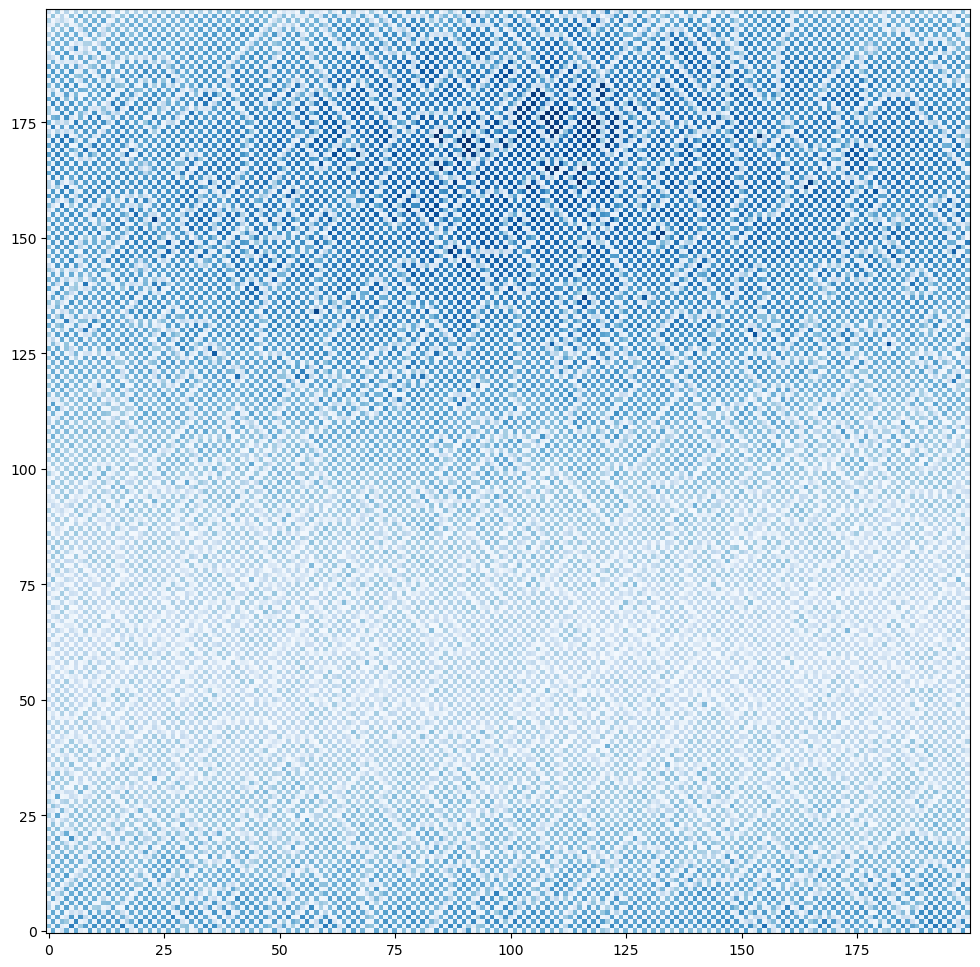

In [291]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
# plt.axis("off")
anim = True
ims = []
# for i in np.arange(len(all_rock)):
i = 400
# tmp = sands[i]
# im1 = ax.imshow(tmp, cmap=plt.cm.Wistia, vmin=0, vmax=0.5, animated=anim, origin="lower")    

# tmp2 = waters[i]


# alphas = tmp2 / 3
# alphas[alphas > 1] = 1
# alphas[alphas < 0.] = 0
# alphas = alphas **1.2
im2 = ax.imshow(waters[i], cmap=plt.cm.Blues, vmin=0, vmax=1, alpha=1, origin="lower")

#     ims.append((im1, im2, im3))
#     ims.append((im1,))

# ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=200, blit=True)

# HTML(ani.to_jshtml())
# 
# ani.save('beach_anim_01.gif', writer='imagemagick', fps=10)